**<font  size=7>策略回測結果報告</font>**

In [383]:
# %%
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
import datetime
from interval3 import Interval, IntervalSet
from tqdm import tqdm
from importlib import reload
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import os

from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Users\chiehlinchen\Desktop\msj.ttf',size=14)
# sns.set(font=myfont.get_family(), rc={'figure.figsize':(5,4)}, font_scale= 2)
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.facecolor']='whitesmoke'

In [384]:
df = pd.read_excel(r"D:\數位金融部專案繳交\123\pred_label.xlsx",index_col= 0)

<font size = 7> HANS123

In [329]:
def filter_n(pred_label,num):
    pred_label = pred_label.sort_values(by = ['datetime', 'score']).reset_index(drop = True)  
    short = pred_label.groupby('datetime').head(num+15).dropna().groupby('datetime').sample(10)
    long = pred_label.groupby('datetime').tail(num+5).dropna().groupby('datetime').sample(5)
    return short, long

In [330]:
returns_short, returns_long = filter_n(df,5)

In [331]:
returns_short = returns_short[(returns_short['label'] >= -0.15) & (returns_short['label'] <= 0.15)]
returns_long = returns_long[(returns_long['label'] >= -0.15) & (returns_long['label'] <= 0.15)]

In [332]:
returns = pd.concat([returns_long,returns_short.assign(label = returns_short['label']*-1)])
returns = returns.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略組合收益(不加成本)'}).drop(columns = 'score')
returns['策略組合收益(0.15%成本)'] = returns['策略組合收益(不加成本)']-0.0015
returns['策略組合收益(0.335%成本)'] = returns['策略組合收益(不加成本)']-0.00335
returns['策略組合收益(0.435%成本)'] = returns['策略組合收益(不加成本)']-0.00435
returns = returns.reset_index(drop = True)

In [333]:
returns_long = returns_long.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略多單收益(不加成本)'}).drop(columns = 'score')
returns_long['策略多單收益(0.15%成本)'] = returns_long['策略多單收益(不加成本)']-0.0015
returns_long['策略多單收益(0.335%成本)'] = returns_long['策略多單收益(不加成本)']-0.00335
returns_long['策略多單收益(0.435%成本)'] = returns_long['策略多單收益(不加成本)']-0.00435
returns_long = returns_long.reset_index(drop = True)

In [334]:
returns_short = returns_short.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略空單收益(不加成本)'}).drop(columns = 'score')
returns_short['策略空單收益(不加成本)'] = returns_short['策略空單收益(不加成本)']*-1
returns_short['策略空單收益(0.15%成本)'] = returns_short['策略空單收益(不加成本)']-0.0015
returns_short['策略空單收益(0.335%成本)'] = returns_short['策略空單收益(不加成本)']-0.00335
returns_short['策略空單收益(0.435%成本)'] = returns_short['策略空單收益(不加成本)']-0.00435
returns_short = returns_short.reset_index(drop = True)

In [335]:
returns_day = returns.groupby('日期').agg({'策略組合收益(0.15%成本)':'mean', '策略組合收益(0.335%成本)': 'mean', '策略組合收益(0.435%成本)':'mean'})
returns_long_day = returns_long.groupby('日期').agg({'策略多單收益(0.15%成本)':'mean', '策略多單收益(0.335%成本)': 'mean', '策略多單收益(0.435%成本)':'mean'})
returns_short_day = returns_short.groupby('日期').agg({'策略空單收益(0.15%成本)':'mean', '策略空單收益(0.335%成本)': 'mean', '策略空單收益(0.435%成本)':'mean'})

In [336]:
returns_day['累積策略組合收益(0.15%成本)'] = returns_day['策略組合收益(0.15%成本)'].cumsum()
returns_day['累積策略組合收益(0.335%成本)'] = returns_day['策略組合收益(0.335%成本)'].cumsum()
returns_day['累積策略組合收益(0.435%成本)'] = returns_day['策略組合收益(0.435%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.15%成本)'] = returns_long_day['策略多單收益(0.15%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.335%成本)'] = returns_long_day['策略多單收益(0.335%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.435%成本)'] = returns_long_day['策略多單收益(0.435%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.15%成本)'] = returns_short_day['策略空單收益(0.15%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.335%成本)'] = returns_short_day['策略空單收益(0.335%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.435%成本)'] = returns_short_day['策略空單收益(0.435%成本)'].cumsum()

**<font  size=4>多單勝率</font>**

In [338]:
pd.concat([pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.15%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.335%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.435%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,多單勝率
勝率(加成本0.15%),0.489970
勝率(加成本0.335%),0.471125
勝率(加成本0.435%),0.451672


In [339]:
pd.concat([pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.15%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.335%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.435%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,多單每日平均勝率
勝率(加成本0.15%),0.565350
勝率(加成本0.335%),0.528875
勝率(加成本0.435%),0.504559


**<font  size=4>多單損益</font>**

<AxesSubplot: xlabel='日期'>

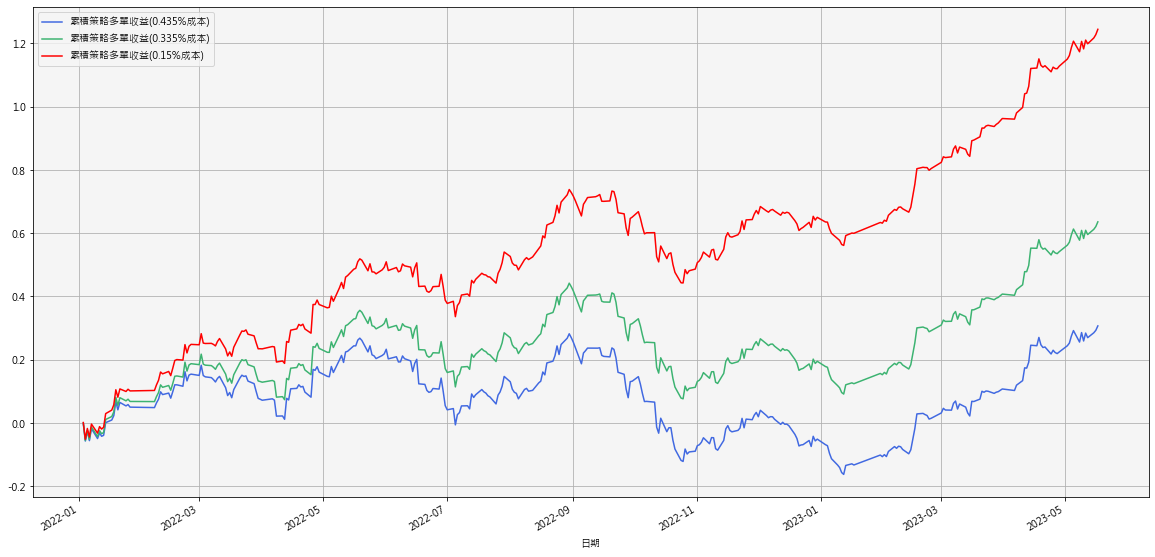

In [344]:
returns_long_day[['累積策略多單收益(0.435%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>多單各年度收益統計</font>**

In [345]:
import pyfolio as pf
import empyrical as ep
from pyfolio.deprecate import deprecated
from pyfolio.interesting_periods import PERIODS
from pyfolio.txn import get_turnover
from pyfolio.utils import APPROX_BDAYS_PER_MONTH, APPROX_BDAYS_PER_YEAR
from pyfolio.utils import DAILY
import scipy.stats as stats
returns_day.index = pd.to_datetime(returns_day.index)

def value_at_risk(returns, period=None, sigma=2.0):
  
    if period is not None:
        returns_agg = ep.aggregate_returns(returns, period)
    else:
        returns_agg = returns.copy()

    value_at_risk = returns_agg.mean() - sigma * returns_agg.std()
    return value_at_risk


SIMPLE_STAT_FUNCS = [
    ep.annual_return,
    ep.cum_returns_final,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.stability_of_timeseries,
    ep.max_drawdown,
    ep.omega_ratio,
    ep.sortino_ratio,
    stats.skew,
    stats.kurtosis,
    ep.tail_ratio,
    value_at_risk
]
STAT_FUNC_NAMES = {
    'annual_return': '年化收益',
    'cum_returns_final': '累積收益',
    'annual_volatility': '年化波動度',
    'sharpe_ratio': '夏普比率',
    'calmar_ratio': 'Calmar 比率',
    'stability_of_timeseries': '穩定度',
    'max_drawdown': '最大回撤',
    'omega_ratio': 'Omega 比率',
    'sortino_ratio': 'Sortino 比率',
    'skew': '偏度',
    'kurtosis': '峰度',
    'tail_ratio': '尾部比率',
    'common_sense_ratio': 'Common sense 比率',
    'value_at_risk': 'Daily value at risk',
    'alpha': 'Alpha',
    'beta': 'Beta',
}

def make_stats(returns,returns_org,colname):
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2020 = df_stats.T
    df_stats_2020.columns = [['2022年','2022年','2022年'],list(df_stats_2020.columns)]
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2021 = df_stats.T
    df_stats_2021.columns = [['2023年','2023年','2023年'],list(df_stats_2021.columns)]
    df_stats = pd.DataFrame()
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_all = df_stats.T
    df_stats_all.columns = [['All','All','All'],list(df_stats_all.columns)]
    df_stats_ed = pd.concat([df_stats_2020,df_stats_2021,df_stats_all],axis = 1)
    df_stats_ed = df_stats_ed.T
    df_stats_ed['總交易次數'] =  [len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),
                                len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),
                                int(len(returns_org)/3.5323),int(len(returns_org)/3.5323),int(len(returns_org)/3.5323)]
    df_stats_ed['勝率'] = [len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']) ,
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']) ,
                            len(returns_org[returns_org[colname +'(0.435%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.335%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.15%成本)']>=0])/len(returns_org)]
    df_stats_ed['勝率'] = df_stats_ed['勝率'].mul(100).round(2).astype(str).add(' %')
    df_stats_ed = df_stats_ed.T

    return df_stats_ed

In [346]:
make_stats(returns_long_day,returns_long,'策略多單收益')['All'].T.assign(累積收益=list((returns_long_day[['累積策略多單收益(0.15%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_long_day[['策略多單收益(0.15%成本)','策略多單收益(0.335%成本)','策略多單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略多單收益(0.435%成本),策略多單收益(0.335%成本),策略多單收益(0.15%成本)
年化收益,23.5%,48.7%,95.32%
累積收益,30.69%,63.59%,124.45%
年化波動度,35.01 %,35.01 %,35.01 %
夏普比率,0.671265,1.390964,2.722406
Calmar 比率,0.503552,1.674447,5.38964
穩定度,0.105575,0.211755,0.817307
最大回撤,-37.71 %,-31.68 %,-26.66 %
Omega 比率,1.119669,1.264368,1.584138
Sortino 比率,0.985982,2.115147,4.4158
偏度,-0.014006,-0.014006,-0.014006


**<font  size=4>空單勝率</font>**

In [347]:
pd.concat([pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.15%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.335%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.435%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,空單勝率
勝率(加成本0.15%),0.608524
勝率(加成本0.335%),0.590563
勝率(加成本0.435%),0.572907


In [348]:
pd.concat([pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.15%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.335%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.435%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,空單每日平均勝率
勝率(加成本0.15%),0.662614
勝率(加成本0.335%),0.617021
勝率(加成本0.435%),0.586626


**<font  size=4>空單損益
</font>**

<AxesSubplot: xlabel='日期'>

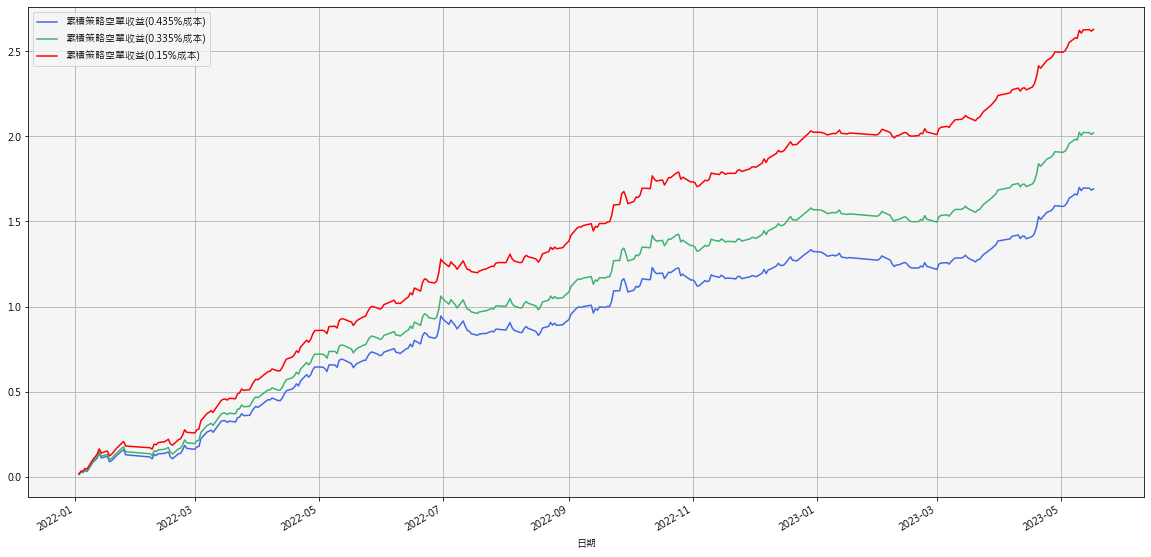

In [353]:
returns_short_day[['累積策略空單收益(0.435%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

In [354]:
make_stats(returns_short_day,returns_short,'策略空單收益')['All'].T.assign(累積收益=list((returns_short_day[['累積策略空單收益(0.15%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_short_day[['策略空單收益(0.15%成本)','策略空單收益(0.335%成本)','策略空單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略空單收益(0.435%成本),策略空單收益(0.335%成本),策略空單收益(0.15%成本)
年化收益,129.57%,154.77%,201.39%
累積收益,169.16%,202.06%,262.93%
年化波動度,30.68 %,30.68 %,30.68 %
夏普比率,4.222666,5.043931,6.563273
Calmar 比率,21.853593,34.803966,73.098362
穩定度,0.931149,0.954243,0.974756
最大回撤,-11.33 %,-9.96 %,-8.34 %
Omega 比率,2.014296,2.314945,2.99746
Sortino 比率,8.113056,10.1936,14.604359
偏度,0.469123,0.469123,0.469123


**<font  size=4>組合損益
</font>**

<AxesSubplot: xlabel='日期'>

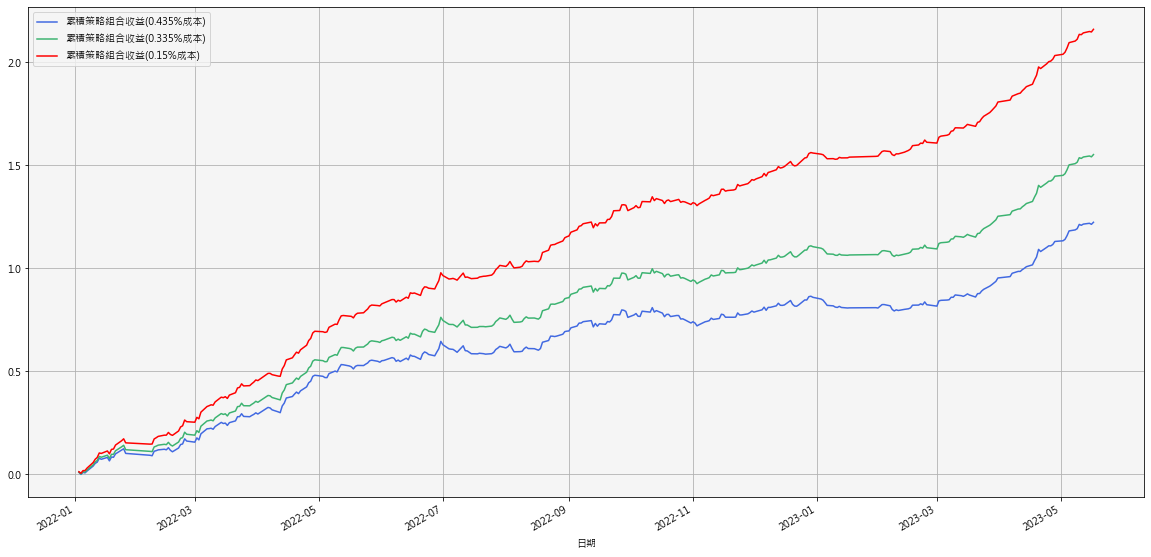

In [359]:
returns_day[['累積策略組合收益(0.435%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>組合各年度收益統計</font>**

In [360]:
make_stats(returns_day,returns,'策略組合收益')['All'].T.assign(累積收益=list((returns_day[['累積策略組合收益(0.15%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_day[['策略組合收益(0.15%成本)','策略組合收益(0.335%成本)','策略組合收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略組合收益(0.435%成本),策略組合收益(0.335%成本),策略組合收益(0.15%成本)
年化收益,93.72%,118.92%,165.54%
累積收益,122.36%,155.26%,216.12%
年化波動度,18.43 %,18.43 %,18.43 %
夏普比率,5.085413,6.452792,8.982445
Calmar 比率,17.554339,31.294165,95.938548
穩定度,0.907371,0.947913,0.975954
最大回撤,-8.58 %,-7.1 %,-4.3 %
Omega 比率,2.284733,2.871112,4.388703
Sortino 比率,9.795348,13.472478,21.884972
偏度,0.12568,0.12568,0.12568


<font size = 7> Rbreaker

In [361]:
def filter_n(pred_label,num):
    pred_label = pred_label.sort_values(by = ['datetime', 'score']).reset_index(drop = True)  
    short = pred_label.groupby('datetime').head(num+15).dropna().groupby('datetime').sample(10)
    long = pred_label.groupby('datetime').tail(num+5).dropna().groupby('datetime').sample(5)
    return short, long

In [362]:
returns_short, returns_long = filter_n(df,5)

In [363]:
returns_short = returns_short[(returns_short['label'] >= -0.15) & (returns_short['label'] <= 0.15)]
returns_long = returns_long[(returns_long['label'] >= -0.15) & (returns_long['label'] <= 0.15)]

In [364]:
returns = pd.concat([returns_long,returns_short.assign(label = returns_short['label']*-1)])
returns = returns.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略組合收益(不加成本)'}).drop(columns = 'score')
returns['策略組合收益(0.15%成本)'] = returns['策略組合收益(不加成本)']-0.0015
returns['策略組合收益(0.335%成本)'] = returns['策略組合收益(不加成本)']-0.00335
returns['策略組合收益(0.435%成本)'] = returns['策略組合收益(不加成本)']-0.00435
returns = returns.reset_index(drop = True)

In [365]:
returns_long = returns_long.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略多單收益(不加成本)'}).drop(columns = 'score')
returns_long['策略多單收益(0.15%成本)'] = returns_long['策略多單收益(不加成本)']-0.0015
returns_long['策略多單收益(0.335%成本)'] = returns_long['策略多單收益(不加成本)']-0.00335
returns_long['策略多單收益(0.435%成本)'] = returns_long['策略多單收益(不加成本)']-0.00435
returns_long = returns_long.reset_index(drop = True)

In [366]:
returns_short = returns_short.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略空單收益(不加成本)'}).drop(columns = 'score')
returns_short['策略空單收益(不加成本)'] = returns_short['策略空單收益(不加成本)']*-1
returns_short['策略空單收益(0.15%成本)'] = returns_short['策略空單收益(不加成本)']-0.0015
returns_short['策略空單收益(0.335%成本)'] = returns_short['策略空單收益(不加成本)']-0.00335
returns_short['策略空單收益(0.435%成本)'] = returns_short['策略空單收益(不加成本)']-0.00435
returns_short = returns_short.reset_index(drop = True)

In [367]:
returns_day = returns.groupby('日期').agg({'策略組合收益(0.15%成本)':'mean', '策略組合收益(0.335%成本)': 'mean', '策略組合收益(0.435%成本)':'mean'})
returns_long_day = returns_long.groupby('日期').agg({'策略多單收益(0.15%成本)':'mean', '策略多單收益(0.335%成本)': 'mean', '策略多單收益(0.435%成本)':'mean'})
returns_short_day = returns_short.groupby('日期').agg({'策略空單收益(0.15%成本)':'mean', '策略空單收益(0.335%成本)': 'mean', '策略空單收益(0.435%成本)':'mean'})

In [368]:
returns_day['累積策略組合收益(0.15%成本)'] = returns_day['策略組合收益(0.15%成本)'].cumsum()
returns_day['累積策略組合收益(0.335%成本)'] = returns_day['策略組合收益(0.335%成本)'].cumsum()
returns_day['累積策略組合收益(0.435%成本)'] = returns_day['策略組合收益(0.435%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.15%成本)'] = returns_long_day['策略多單收益(0.15%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.335%成本)'] = returns_long_day['策略多單收益(0.335%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.435%成本)'] = returns_long_day['策略多單收益(0.435%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.15%成本)'] = returns_short_day['策略空單收益(0.15%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.335%成本)'] = returns_short_day['策略空單收益(0.335%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.435%成本)'] = returns_short_day['策略空單收益(0.435%成本)'].cumsum()

**<font  size=4>多單勝率</font>**

In [369]:
pd.concat([pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.15%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.335%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.435%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,多單勝率
勝率(加成本0.15%),0.487820
勝率(加成本0.335%),0.468940
勝率(加成本0.435%),0.454324


In [370]:
pd.concat([pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.15%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.335%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.435%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,多單每日平均勝率
勝率(加成本0.15%),0.580547
勝率(加成本0.335%),0.531915
勝率(加成本0.435%),0.510638


**<font  size=4>多單損益</font>**

<AxesSubplot: xlabel='日期'>

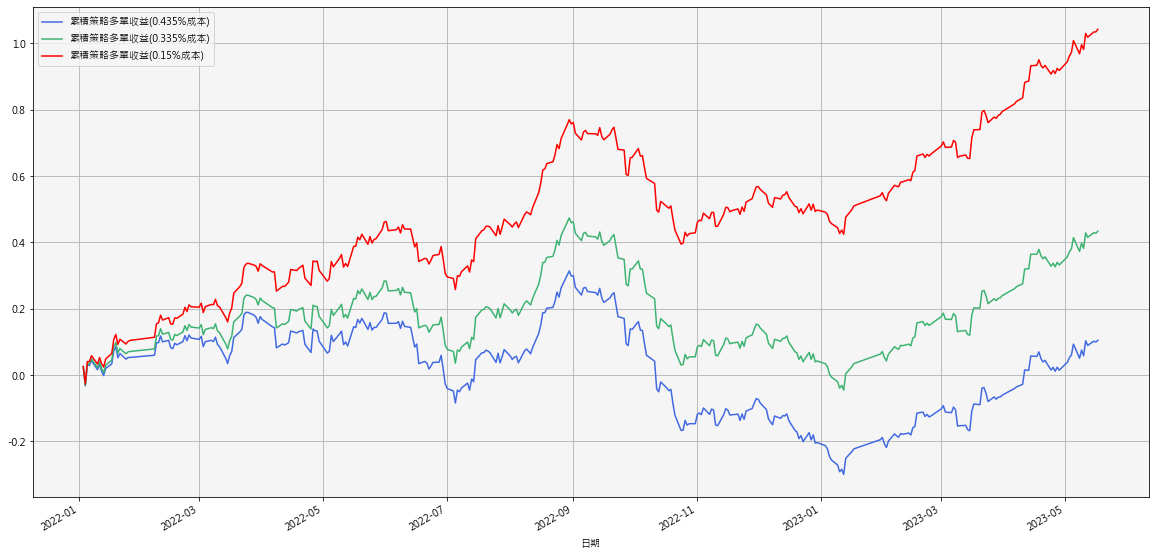

In [372]:
returns_long_day[['累積策略多單收益(0.435%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>多單各年度收益統計</font>**

In [373]:
import pyfolio as pf
import empyrical as ep
from pyfolio.deprecate import deprecated
from pyfolio.interesting_periods import PERIODS
from pyfolio.txn import get_turnover
from pyfolio.utils import APPROX_BDAYS_PER_MONTH, APPROX_BDAYS_PER_YEAR
from pyfolio.utils import DAILY
import scipy.stats as stats
returns_day.index = pd.to_datetime(returns_day.index)

def value_at_risk(returns, period=None, sigma=2.0):
  
    if period is not None:
        returns_agg = ep.aggregate_returns(returns, period)
    else:
        returns_agg = returns.copy()

    value_at_risk = returns_agg.mean() - sigma * returns_agg.std()
    return value_at_risk


SIMPLE_STAT_FUNCS = [
    ep.annual_return,
    ep.cum_returns_final,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.stability_of_timeseries,
    ep.max_drawdown,
    ep.omega_ratio,
    ep.sortino_ratio,
    stats.skew,
    stats.kurtosis,
    ep.tail_ratio,
    value_at_risk
]
STAT_FUNC_NAMES = {
    'annual_return': '年化收益',
    'cum_returns_final': '累積收益',
    'annual_volatility': '年化波動度',
    'sharpe_ratio': '夏普比率',
    'calmar_ratio': 'Calmar 比率',
    'stability_of_timeseries': '穩定度',
    'max_drawdown': '最大回撤',
    'omega_ratio': 'Omega 比率',
    'sortino_ratio': 'Sortino 比率',
    'skew': '偏度',
    'kurtosis': '峰度',
    'tail_ratio': '尾部比率',
    'common_sense_ratio': 'Common sense 比率',
    'value_at_risk': 'Daily value at risk',
    'alpha': 'Alpha',
    'beta': 'Beta',
}

def make_stats(returns,returns_org,colname):
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2020 = df_stats.T
    df_stats_2020.columns = [['2022年','2022年','2022年'],list(df_stats_2020.columns)]
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2021 = df_stats.T
    df_stats_2021.columns = [['2023年','2023年','2023年'],list(df_stats_2021.columns)]
    df_stats = pd.DataFrame()
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_all = df_stats.T
    df_stats_all.columns = [['All','All','All'],list(df_stats_all.columns)]
    df_stats_ed = pd.concat([df_stats_2020,df_stats_2021,df_stats_all],axis = 1)
    df_stats_ed = df_stats_ed.T
    df_stats_ed['總交易次數'] =  [len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),
                                len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),
                                int(len(returns_org)/3.673),int(len(returns_org)/3.673),int(len(returns_org)/3.673)]
    df_stats_ed['勝率'] = [len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']) ,
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']) ,
                            len(returns_org[returns_org[colname +'(0.435%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.335%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.15%成本)']>=0])/len(returns_org)]
    df_stats_ed['勝率'] = df_stats_ed['勝率'].mul(100).round(2).astype(str).add(' %')
    df_stats_ed = df_stats_ed.T

    return df_stats_ed

In [374]:
make_stats(returns_long_day,returns_long,'策略多單收益')['All'].T.assign(累積收益=list((returns_long_day[['累積策略多單收益(0.15%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_long_day[['策略多單收益(0.15%成本)','策略多單收益(0.335%成本)','策略多單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略多單收益(0.435%成本),策略多單收益(0.335%成本),策略多單收益(0.15%成本)
年化收益,8.0%,33.2%,79.82%
累積收益,10.45%,43.35%,104.21%
年化波動度,36.49 %,36.49 %,36.49 %
夏普比率,0.219243,0.909778,2.187267
Calmar 比率,0.028835,0.724321,3.328279
穩定度,0.421445,0.00049,0.697387
最大回撤,-47.21 %,-41.97 %,-32.35 %
Omega 比率,1.037055,1.162834,1.436312
Sortino 比率,0.312046,1.338306,3.422478
偏度,-0.062513,-0.062513,-0.062513


**<font  size=4>空單勝率</font>**

In [375]:
pd.concat([pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.15%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.335%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.435%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,空單勝率
勝率(加成本0.15%),0.617468
勝率(加成本0.335%),0.594035
勝率(加成本0.435%),0.578819


In [376]:
pd.concat([pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.15%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.335%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.435%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,空單每日平均勝率
勝率(加成本0.15%),0.644377
勝率(加成本0.335%),0.595745
勝率(加成本0.435%),0.580547


**<font  size=4>空單損益
</font>**

<AxesSubplot: xlabel='日期'>

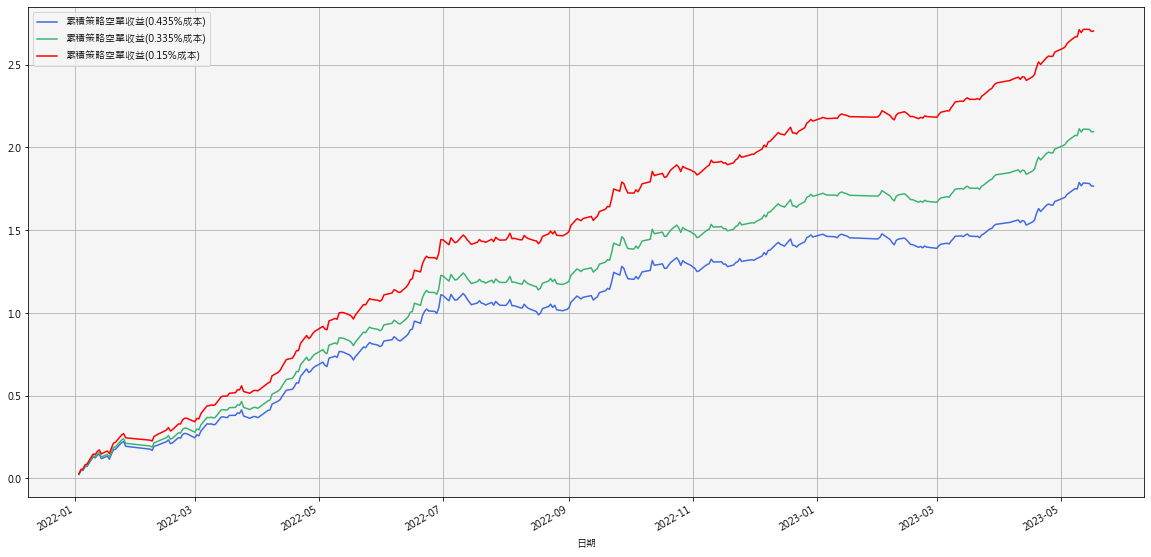

In [378]:
returns_short_day[['累積策略空單收益(0.435%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

In [379]:
make_stats(returns_short_day,returns_short,'策略空單收益')['All'].T.assign(累積收益=list((returns_short_day[['累積策略空單收益(0.15%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_short_day[['策略空單收益(0.15%成本)','策略空單收益(0.335%成本)','策略空單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略空單收益(0.435%成本),策略空單收益(0.335%成本),策略空單收益(0.15%成本)
年化收益,135.31%,160.51%,207.13%
累積收益,176.66%,209.56%,270.42%
年化波動度,30.35 %,30.35 %,30.35 %
夏普比率,4.457745,5.287933,6.823782
Calmar 比率,21.605705,37.271787,98.912299
穩定度,0.925451,0.948955,0.97086
最大回撤,-12.43 %,-10.02 %,-6.59 %
Omega 比率,2.069104,2.380844,3.103004
Sortino 比率,8.87577,11.125873,15.957471
偏度,0.483618,0.483618,0.483618


**<font  size=4>組合損益
</font>**

<AxesSubplot: xlabel='日期'>

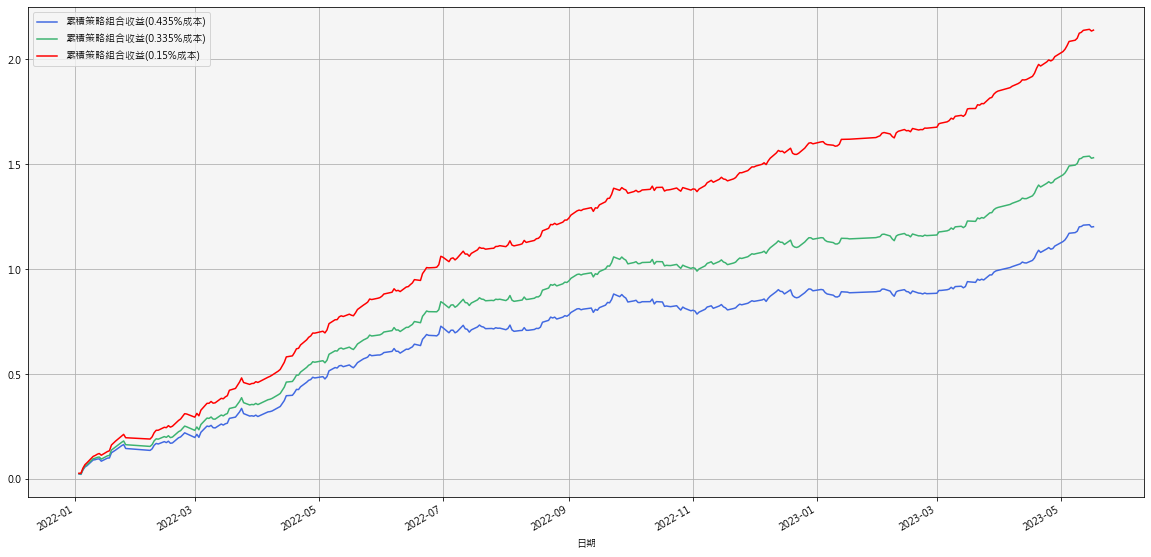

In [381]:
returns_day[['累積策略組合收益(0.435%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>組合各年度收益統計</font>**

In [382]:
make_stats(returns_day,returns,'策略組合收益')['All'].T.assign(累積收益=list((returns_day[['累積策略組合收益(0.15%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_day[['策略組合收益(0.15%成本)','策略組合收益(0.335%成本)','策略組合收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略組合收益(0.435%成本),策略組合收益(0.335%成本),策略組合收益(0.15%成本)
年化收益,92.08%,117.28%,163.9%
累積收益,120.21%,153.11%,213.98%
年化波動度,17.27 %,17.27 %,17.27 %
夏普比率,5.331304,6.790367,9.489633
Calmar 比率,15.83555,32.458668,131.586729
穩定度,0.892643,0.939022,0.971629
最大回撤,-9.28 %,-6.7 %,-3.08 %
Omega 比率,2.339165,2.959205,4.569311
Sortino 比率,10.034929,13.884819,22.75579
偏度,0.012645,0.012645,0.012645


<font size = 7> 上下界突破

In [385]:
def filter_n(pred_label,num):
    pred_label = pred_label.sort_values(by = ['datetime', 'score']).reset_index(drop = True)  
    short = pred_label.groupby('datetime').head(num+15).dropna().groupby('datetime').sample(10)
    long = pred_label.groupby('datetime').tail(num+5).dropna().groupby('datetime').sample(5)
    return short, long

In [386]:
returns_short, returns_long = filter_n(df,5)

In [387]:
returns_short = returns_short[(returns_short['label'] >= -0.15) & (returns_short['label'] <= 0.15)]
returns_long = returns_long[(returns_long['label'] >= -0.15) & (returns_long['label'] <= 0.15)]

In [388]:
returns = pd.concat([returns_long,returns_short.assign(label = returns_short['label']*-1)])
returns = returns.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略組合收益(不加成本)'}).drop(columns = 'score')
returns['策略組合收益(0.15%成本)'] = returns['策略組合收益(不加成本)']-0.0015
returns['策略組合收益(0.335%成本)'] = returns['策略組合收益(不加成本)']-0.00335
returns['策略組合收益(0.435%成本)'] = returns['策略組合收益(不加成本)']-0.00435
returns = returns.reset_index(drop = True)

In [389]:
returns_long = returns_long.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略多單收益(不加成本)'}).drop(columns = 'score')
returns_long['策略多單收益(0.15%成本)'] = returns_long['策略多單收益(不加成本)']-0.0015
returns_long['策略多單收益(0.335%成本)'] = returns_long['策略多單收益(不加成本)']-0.00335
returns_long['策略多單收益(0.435%成本)'] = returns_long['策略多單收益(不加成本)']-0.00435
returns_long = returns_long.reset_index(drop = True)

In [390]:
returns_short = returns_short.rename(columns = {'datetime':'日期','instrument':'symbol','label':'策略空單收益(不加成本)'}).drop(columns = 'score')
returns_short['策略空單收益(不加成本)'] = returns_short['策略空單收益(不加成本)']*-1
returns_short['策略空單收益(0.15%成本)'] = returns_short['策略空單收益(不加成本)']-0.0015
returns_short['策略空單收益(0.335%成本)'] = returns_short['策略空單收益(不加成本)']-0.00335
returns_short['策略空單收益(0.435%成本)'] = returns_short['策略空單收益(不加成本)']-0.00435
returns_short = returns_short.reset_index(drop = True)

In [391]:
returns_day = returns.groupby('日期').agg({'策略組合收益(0.15%成本)':'mean', '策略組合收益(0.335%成本)': 'mean', '策略組合收益(0.435%成本)':'mean'})
returns_long_day = returns_long.groupby('日期').agg({'策略多單收益(0.15%成本)':'mean', '策略多單收益(0.335%成本)': 'mean', '策略多單收益(0.435%成本)':'mean'})
returns_short_day = returns_short.groupby('日期').agg({'策略空單收益(0.15%成本)':'mean', '策略空單收益(0.335%成本)': 'mean', '策略空單收益(0.435%成本)':'mean'})

In [392]:
returns_day['累積策略組合收益(0.15%成本)'] = returns_day['策略組合收益(0.15%成本)'].cumsum()
returns_day['累積策略組合收益(0.335%成本)'] = returns_day['策略組合收益(0.335%成本)'].cumsum()
returns_day['累積策略組合收益(0.435%成本)'] = returns_day['策略組合收益(0.435%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.15%成本)'] = returns_long_day['策略多單收益(0.15%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.335%成本)'] = returns_long_day['策略多單收益(0.335%成本)'].cumsum()
returns_long_day['累積策略多單收益(0.435%成本)'] = returns_long_day['策略多單收益(0.435%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.15%成本)'] = returns_short_day['策略空單收益(0.15%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.335%成本)'] = returns_short_day['策略空單收益(0.335%成本)'].cumsum()
returns_short_day['累積策略空單收益(0.435%成本)'] = returns_short_day['策略空單收益(0.435%成本)'].cumsum()

**<font  size=4>多單勝率</font>**

In [393]:
pd.concat([pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.15%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.335%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單勝率':len(returns_long[returns_long['策略多單收益(0.435%成本)']>0])/len(returns_long)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,多單勝率
勝率(加成本0.15%),0.489349
勝率(加成本0.335%),0.469264
勝率(加成本0.435%),0.447352


In [394]:
pd.concat([pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.15%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.335%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(returns_long_day[returns_long_day['策略多單收益(0.435%成本)'] >0 ])/len(returns_long_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,多單每日平均勝率
勝率(加成本0.15%),0.562310
勝率(加成本0.335%),0.504559
勝率(加成本0.435%),0.492401


**<font  size=4>多單損益</font>**

<AxesSubplot: xlabel='日期'>

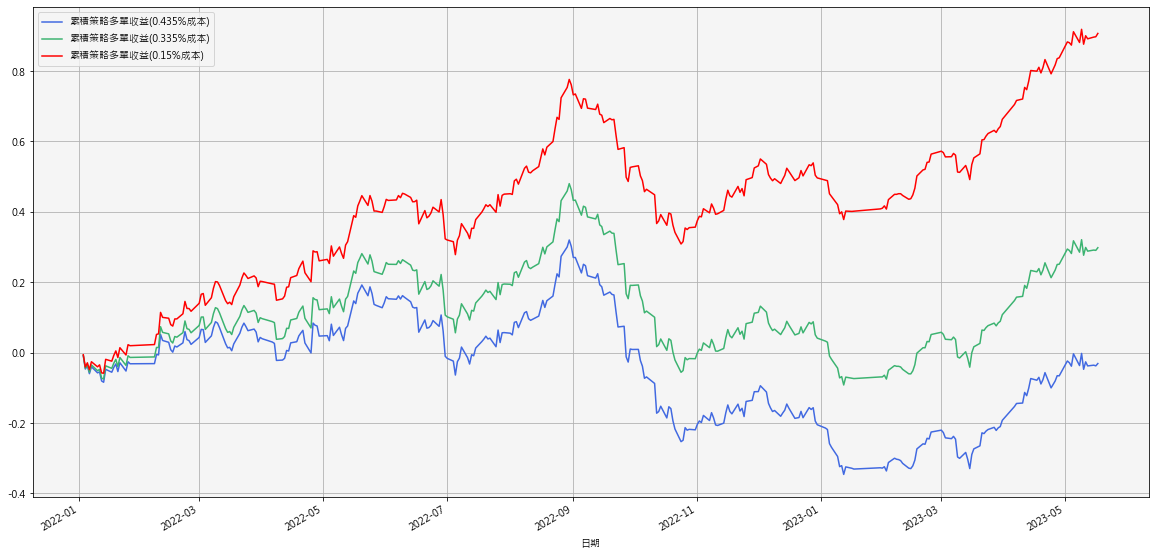

In [395]:
returns_long_day[['累積策略多單收益(0.435%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>多單各年度收益統計</font>**

In [404]:
import pyfolio as pf
import empyrical as ep
from pyfolio.deprecate import deprecated
from pyfolio.interesting_periods import PERIODS
from pyfolio.txn import get_turnover
from pyfolio.utils import APPROX_BDAYS_PER_MONTH, APPROX_BDAYS_PER_YEAR
from pyfolio.utils import DAILY
import scipy.stats as stats
returns_day.index = pd.to_datetime(returns_day.index)

def value_at_risk(returns, period=None, sigma=2.0):
  
    if period is not None:
        returns_agg = ep.aggregate_returns(returns, period)
    else:
        returns_agg = returns.copy()

    value_at_risk = returns_agg.mean() - sigma * returns_agg.std()
    return value_at_risk


SIMPLE_STAT_FUNCS = [
    ep.annual_return,
    ep.cum_returns_final,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.stability_of_timeseries,
    ep.max_drawdown,
    ep.omega_ratio,
    ep.sortino_ratio,
    stats.skew,
    stats.kurtosis,
    ep.tail_ratio,
    value_at_risk
]
STAT_FUNC_NAMES = {
    'annual_return': '年化收益',
    'cum_returns_final': '累積收益',
    'annual_volatility': '年化波動度',
    'sharpe_ratio': '夏普比率',
    'calmar_ratio': 'Calmar 比率',
    'stability_of_timeseries': '穩定度',
    'max_drawdown': '最大回撤',
    'omega_ratio': 'Omega 比率',
    'sortino_ratio': 'Sortino 比率',
    'skew': '偏度',
    'kurtosis': '峰度',
    'tail_ratio': '尾部比率',
    'common_sense_ratio': 'Common sense 比率',
    'value_at_risk': 'Daily value at risk',
    'alpha': 'Alpha',
    'beta': 'Beta',
}

def make_stats(returns,returns_org,colname):
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index <='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2020 = df_stats.T
    df_stats_2020.columns = [['2022年','2022年','2022年'],list(df_stats_2020.columns)]
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[returns.index >='20230101'][colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_2021 = df_stats.T
    df_stats_2021.columns = [['2023年','2023年','2023年'],list(df_stats_2021.columns)]
    df_stats = pd.DataFrame()
    df_stats = pd.DataFrame()
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname + '(0.435%成本)'])
    df_stats[colname + '(0.435%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.335%成本)'])
    df_stats[colname +'(0.335%成本)'] = stats
    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns[colname +'(0.15%成本)'])
    df_stats[colname +'(0.15%成本)'] = stats
    df_stats = df_stats.T
    df_stats['年化收益'] = df_stats['年化收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['累積收益'] = df_stats['累積收益'].mul(100).round(2).astype(str).add(' %')
    df_stats['年化波動度'] = df_stats['年化波動度'].mul(100).round(2).astype(str).add(' %')
    df_stats['最大回撤'] = df_stats['最大回撤'].mul(100).round(2).astype(str).add(' %')
    df_stats['Daily value at risk'] = df_stats['Daily value at risk'].mul(100).round(2).astype(str).add(' %')
    df_stats_all = df_stats.T
    df_stats_all.columns = [['All','All','All'],list(df_stats_all.columns)]
    df_stats_ed = pd.concat([df_stats_2020,df_stats_2021,df_stats_all],axis = 1)
    df_stats_ed = df_stats_ed.T
    df_stats_ed['總交易次數'] =  [len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),len(returns_org[returns_org['日期'] <= '20221213']),
                                len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),len(returns_org[returns_org['日期'] > '20221213']),
                                int(len(returns_org)/2.5894),int(len(returns_org)/2.5894),int(len(returns_org)/2.5894)]
    df_stats_ed['勝率'] = [len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname+'(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']),
                            len(returns_org[returns_org['日期'] <= '20221213'][returns_org[returns_org['日期'] <= '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] <= '20221213']) ,
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.435%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname+ '(0.335%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']),
                            len(returns_org[returns_org['日期'] > '20221213'][returns_org[returns_org['日期'] > '20221213'][colname + '(0.15%成本)']>=0])/len(returns_org[returns_org['日期'] > '20221213']) ,
                            len(returns_org[returns_org[colname +'(0.435%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.335%成本)']>=0])/len(returns_org) ,
                            len(returns_org[returns_org[colname + '(0.15%成本)']>=0])/len(returns_org)]
    df_stats_ed['勝率'] = df_stats_ed['勝率'].mul(100).round(2).astype(str).add(' %')
    df_stats_ed = df_stats_ed.T

    return df_stats_ed

In [405]:
make_stats(returns_long_day,returns_long,'策略多單收益')['All'].T.assign(累積收益=list((returns_long_day[['累積策略多單收益(0.15%成本)','累積策略多單收益(0.335%成本)','累積策略多單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_long_day[['策略多單收益(0.15%成本)','策略多單收益(0.335%成本)','策略多單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略多單收益(0.435%成本),策略多單收益(0.335%成本),策略多單收益(0.15%成本)
年化收益,-2.38%,22.82%,69.44%
累積收益,-3.11%,29.79%,90.65%
年化波動度,36.79 %,36.79 %,36.79 %
夏普比率,-0.064753,0.620146,1.887208
Calmar 比率,-0.174907,0.385915,2.267785
穩定度,0.480317,0.03708,0.59866
最大回撤,-50.05 %,-45.09 %,-38.37 %
Omega 比率,0.989242,1.109271,1.370628
Sortino 比率,-0.089478,0.88419,2.852063
偏度,-0.202538,-0.202538,-0.202538


**<font  size=4>空單勝率</font>**

In [398]:
pd.concat([pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.15%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.335%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單勝率':len(returns_short[returns_short['策略空單收益(0.435%成本)']>0])/len(returns_short)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])


,空單勝率
勝率(加成本0.15%),0.613512
勝率(加成本0.335%),0.593122
勝率(加成本0.435%),0.576689


In [399]:
pd.concat([pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.15%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.335%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'空單每日平均勝率':len(returns_short_day[returns_short_day['策略空單收益(0.435%成本)'] >0 ])/len(returns_short_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,空單每日平均勝率
勝率(加成本0.15%),0.647416
勝率(加成本0.335%),0.598784
勝率(加成本0.435%),0.586626


**<font  size=4>空單損益
</font>**

<AxesSubplot: xlabel='日期'>

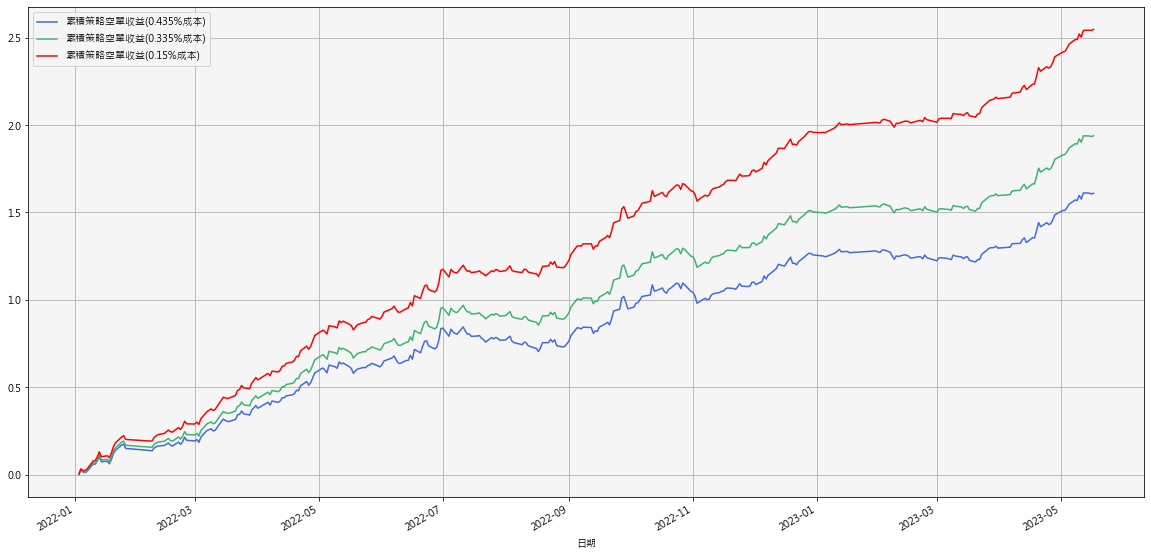

In [400]:
returns_short_day[['累積策略空單收益(0.435%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

In [406]:
make_stats(returns_short_day,returns_short,'策略空單收益')['All'].T.assign(累積收益=list((returns_short_day[['累積策略空單收益(0.15%成本)','累積策略空單收益(0.335%成本)','累積策略空單收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_short_day[['策略空單收益(0.15%成本)','策略空單收益(0.335%成本)','策略空單收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略空單收益(0.435%成本),策略空單收益(0.335%成本),策略空單收益(0.15%成本)
年化收益,123.28%,148.48%,195.1%
累積收益,160.95%,193.85%,254.72%
年化波動度,30.15 %,30.15 %,30.15 %
夏普比率,4.089267,4.925154,6.471545
Calmar 比率,17.013097,29.211859,58.510095
穩定度,0.958235,0.972903,0.985413
最大回撤,-13.35 %,-10.96 %,-9.71 %
Omega 比率,1.950092,2.242923,2.916802
Sortino 比率,7.614835,9.641099,13.924482
偏度,0.27754,0.27754,0.27754


**<font  size=4>組合損益
</font>**

<AxesSubplot: xlabel='日期'>

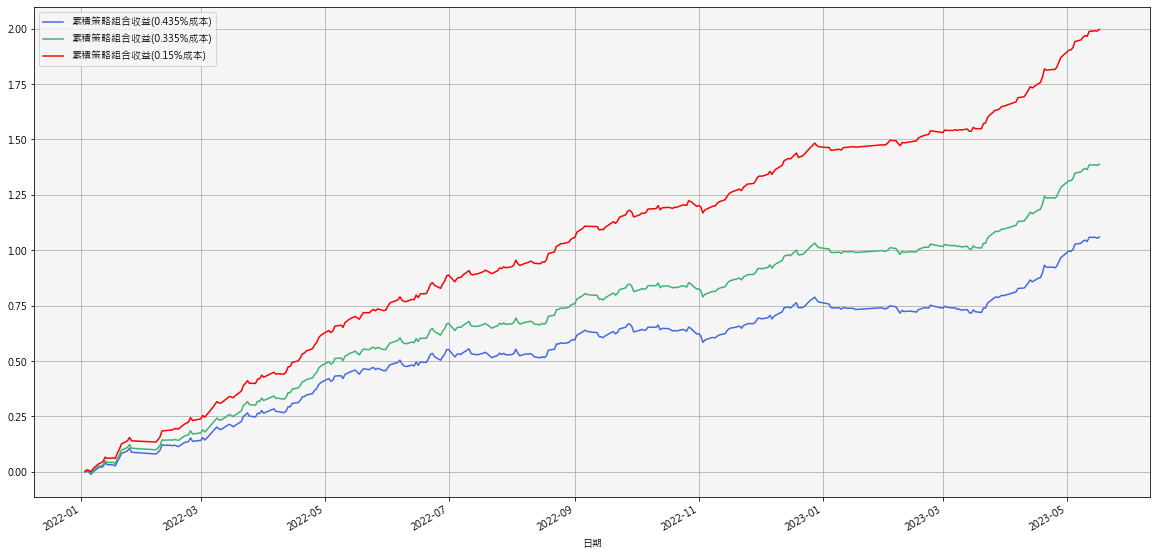

In [402]:
returns_day[['累積策略組合收益(0.435%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.15%成本)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=3>組合各年度收益統計</font>**

In [407]:
make_stats(returns_day,returns,'策略組合收益')['All'].T.assign(累積收益=list((returns_day[['累積策略組合收益(0.15%成本)','累積策略組合收益(0.335%成本)','累積策略組合收益(0.435%成本)']][-1:].T['2023-05-17']*100).round(2).astype(str).add("%"))[::-1],年化收益 = list((returns_day[['策略組合收益(0.15%成本)','策略組合收益(0.335%成本)','策略組合收益(0.435%成本)']].mean()*252*100).round(2).astype(str).add("%"))[::-1]).T

,策略組合收益(0.435%成本),策略組合收益(0.335%成本),策略組合收益(0.15%成本)
年化收益,81.13%,106.33%,152.95%
累積收益,105.92%,138.82%,199.68%
年化波動度,17.42 %,17.42 %,17.42 %
夏普比率,4.656512,6.102945,8.778848
Calmar 比率,14.85752,29.324532,65.124458
穩定度,0.910904,0.953576,0.980027
最大回撤,-8.17 %,-6.3 %,-5.41 %
Omega 比率,2.115421,2.687945,4.185025
Sortino 比率,8.349481,11.824976,19.674827
偏度,-0.096421,-0.096421,-0.096421
